 Date 2016/07/07 06:00 UTC
AAAAAA
BBBBBB
CCCCCC
<xarray.DataArray 'irwin_cdr' (lat: 357, lon: 500)>
array([[ 7.700012,  7.700012,  8.380005, ..., 21.769989, 21.570007, 20.329987],
       [ 4.880005,  4.880005,  4.880005, ..., 22.899994, 22.800018, 22.179993],
       [ 9.589996,  9.589996,  9.589996, ..., 23.      , 22.690002, 22.589996],
       ...,
       [15.130005,  9.440002,  9.440002, ..., 20.99002 , 20.779999, 20.779999],
       [11.26001 , 14.490021,  8.119995, ..., 25.550018, 22.01001 , 20.079987],
       [12.950012, 12.950012, 11.490021, ..., 25.550018, 22.01001 , 20.079987]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 10.010002 10.080002 10.150002 ... 34.79 34.86 34.93
  * lon      (lon) float32 105.04001 105.110016 105.17999 ... 139.9 139.97
    time     datetime64[ns] 2016-07-07T06:00:00
<xarray.DataArray 'time' (time: 1)>
array(['2016-07-07T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-07-07T06:00:00
At

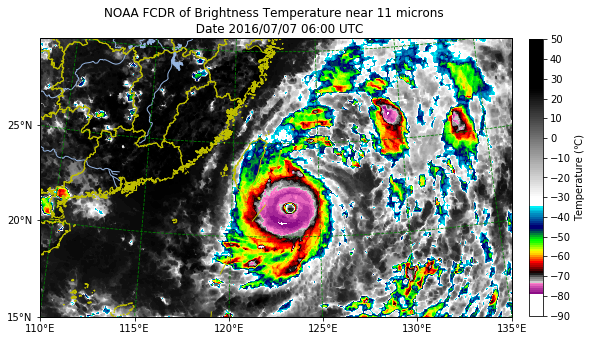

In [4]:
import os,sys
import scipy.ndimage
import numpy as np
import xarray as xr
from copy import copy
import matplotlib.pyplot as plt # Import the Matplotlib package
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom

def find_side(ls, side):
    """
 Given a shapely LineString which is assumed to be rectangular, return the
 line corresponding to a given side of the rectangle.

 """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible: 
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels







# 区域选择
lat_s = 15
lat_n = 30
lon_w = 110
lon_e = 135


# Load the border data, CN-border-La.dat is downloaded from
# https://gmt-china.org/data/CN-border-La.dat
with open('CN-border-La.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]
 

path = '/Users/zhpfu/Dropbox/Code_Fortress/00_My_Python_Library/Typhoon/GRIDSAT-B1.2016.07.07.06.v02r01.nc'

# Search for the Scan start in the file name  2016.07.07.06
Start = (path[path.find("B1.")+3:path.find(".v02")])
Start_Formatted = " Date "+ Start[0:4] + "/" + Start[5:7] + "/" + Start [8:10]+ " " + Start [11:13]+":00 UTC"

print(Start_Formatted)



# Set figure size 
proj = ccrs.LambertConformal(central_longitude=(lon_w+lon_e)/2., central_latitude= (lat_s+lat_n)/2.,
                             false_easting=400000, false_northing=400000)#,standard_parallels=(46, 49))

fig = plt.figure(figsize=[10, 8],frameon=True)

print("AAAAAA")

# Set projection and plot the main figure
ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)

# Set figure extent
ax.set_extent([lon_w, lon_e, lat_s, lat_n],crs=ccrs.PlateCarree())

# Plot border lines
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1.0, color='y',
            transform=ccrs.Geodetic())

# Add ocean, land, rivers and lakes
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))

print("BBBBBB")

# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
# xticks = [] ; yticks = []  
npts   = 5
xticks = list(np.arange(lon_w-15,lon_e+15+1,npts))
yticks = list(np.arange(lat_s-15,lat_n+15+1,npts))


ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=0.85,color='green')# dimgrey

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)


print("CCCCCC")

# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation
cpt_convert = LinearSegmentedColormap('cpt', cpt)
 

ds    = xr.open_dataset(path)
lat   = ds.lat
lon   = ds.lon
time  = ds.time
data0 = (ds['irwin_cdr'][0,:,:] - 273.15 ) # 把温度转换为℃  - 273.15


lon_range = lon[(lon>lon_w-5) & (lon<lon_e+5)]
lat_range = lat[(lat>lat_s-5) & (lat<lat_n+5)]
data     = data0.sel(lon=lon_range, lat=lat_range)

print(data)
print(time)
 

# 设置colorbar 
#get size and extent of axes:
cbar_kwargs = {
    'orientation': 'vertical',    #'horizontal',
    'label': 'Temperature (℃)',
    'ticks': np.arange(-90, 50 + 1, 10),
    'pad': 0.03,
    'shrink': 0.51
}

levels = np.arange(-90, 50 + 1, 1) # .reversed() ,, vmin=-90, vmax=50, .reversed() 
# 
# Resample your data grid by a factor of 3 using cubic spline interpolation.
# data = scipy.ndimage.zoom(data, 3)
# 
# from scipy.ndimage.filters import gaussian_filter
# sigma = 0.7 # this depends on how noisy your data is, play with it!
# data = gaussian_filter(data, sigma)
# 
data.plot.contourf(ax=ax, levels=levels, vmin=-90, vmax=50, cmap=cpt_convert, origin='upper',
                   cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())

#http://xarray.pydata.org/en/stable/plotting.html
plt.ylabel('')    #Remove the defult  lat / lon label  
plt.xlabel('')

print("DDDDDD")

# Add a title to the plot
plt.title("NOAA FCDR of Brightness Temperature near 11 microns "+ "\n " + Start_Formatted)

# Save & Show figure
(filename, extension) = os.path.splitext(os.path.basename(sys.argv[0]))
plt.savefig(filename+".png", dpi=600, bbox_inches='tight')
print("EEEEEE")
plt.show()